# Bitcoin price prediction with CNN

In this part, we are going to demonstrate how to use deep neural networks (DNN) to predict bitcoin price. The DNN we are using in this section is mostly feed-forward networks, and in the next section, the recurrent neural network (RNN) will be dicussed and some solid examples will be provided to demonstrate how to use RNN and LSTM (a special type of RNN) to perform time serial analysis. We are going to use two types of DNN: MultiLayer Perceptron (MLP) and Convolutional Neural Networks (CNN). 


## MLP vs CNN

MLP is probably one of the oldest DNN mode and we have showed its network structure in above Figure 8. In the MLP, every neuron of current layer will have one connection of every other neurons of the next layer. Thata's why the layers of MLP is also called fully connected layer of dense layer. 
CNN is invented to process 2D image, however in the recent years it is also widely used in time series data such as natural langurate process, or human activity recognition from accelerometer data recorded by smart phones or other wearable devices. 

https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf

It is natural to think that MLP is helpful for the time series application. In this case, MLP is a lot like the traditional regression problem where we are trying to design a model to be able to regree the input data. The difference is there is no need to design the mathmatically model by hand, we just need define how many neurons we need in MLP and the weights of the connections between different neurons regress the training data. The problem with MLP is the connections are so dense and it is very easy to overfit the training data. 

As for 1D CNN, it is trying to find pattern of the fixed segment of time series data. For each to-be-found pattern, we just define a set of parameters and we can predefine how many patterns we would like to reveal from each segment by experience. Therefore, the CNN is very effective and requires much less connections between neurons acorss layers. 

We would like to apply both MLP and CNN in time series application with below bitcoin history data.

## Bitcoin price prediction with CNN and MLP

### Dataset

The dataset we are using is the bitcoin historical data from Jan 2012 to March 2019, and can be downloaded from kaggle website: https://www.kaggle.com/mczielinski/bitcoin-historical-data. The original dataset contains the bitcoin history data updated every minute with Open, High, Low and Close prices. In this demonstraction, we average the close prices happening in each day and will use MLP and CNN to predict the next 5 days of bitcoin price with the past 10 days price.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

In [2]:
bit_data = pd.read_csv("./data/bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv")
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group = bit_data.groupby("date")
data = group["Close"].mean()

### Data Visualization and Preparation

There are 2627 valid date points in from Jan 2012 to March 2019. The original data is illustrated in the left of the figure in below. It can be observed that the price is relatively flat betwen 2012 and 2017 and then rises to increditable high in begining of 2018 before falling later on. The original data is normalized first so that the model will treat every section of the data equally. 

The time series bitcoin data here only have X samples and both CNN and MLP are supervise learning models therefore we need to generate the ground truth label X. The goal here is to use the last 10 days of bitcoin price to predict the following 5 days, so both MLP and CNN are trying to find a mappping function so that 
X[t15,..,t19] = f( X[t0,...,t14]) and the groundtruth y = X[t15,..,t19], where ti is a time point. 

The whole 2627 data is also split into two parts: the first 70% is used as training data and the remaining 30% will be served as test data to evaludate the model accuracy after the training is complete. 

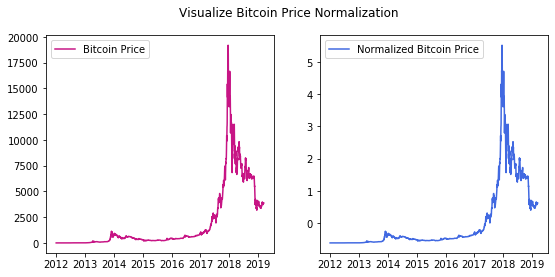

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

data_n = data.values
scaler = preprocessing.StandardScaler()
data_scaled = scaler.fit_transform(data_n.reshape(-1,1))


fig=plt.figure(figsize=(9,4))
fig.suptitle('Visualize Bitcoin Price Normalization')
plt.subplot(1,2,1)
plt.plot(data.keys(), data_n, '-', color='mediumvioletred', label='Bitcoin Price')
plt.legend(loc='upper left')
plt.subplot(1,2,2)
plt.plot(data.keys(), data_scaled, color='royalblue', label='Normalized Bitcoin Price')
plt.legend(loc='upper left')
fig.savefig("bitcoin_price_normalization.png")

In [4]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [5]:
from sklearn.model_selection import train_test_split

test_size = 0.3
time_window_length = 10
prediction_time = 5

X, y = to_supervised(data_scaled.reshape(-1,1,1), time_window_length, prediction_time)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size=test_size, random_state=42)
# see the shape
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1828, 10, 1)
y_train (1828, 5)
X_test (784, 10, 1)
y_test (784, 5)


In [6]:
n_steps = time_window_length
n_features = 1

## Build MLP and CNN models

The MLP model used in this task consists of multiple dense layer (or fully connected layer), where each neuron in the previous layer will have a connection to every neuron the next layer). Due to use of dense layers, there are a lot of parameters to be trained in MLP model. In the MLP model we built, there are 21,509 parameters to be trained. 

In [7]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten 
from keras.layers import Conv1D, MaxPooling1D

Using TensorFlow backend.


In [8]:
# define MLP  model
model_mlp = Sequential()
model_mlp.add(Dense(256, activation='relu', input_dim=n_steps))
model_mlp.add(Dense(64, activation='relu', input_dim=n_steps))
model_mlp.add(Dense(32, activation='relu', input_dim=n_steps))
model_mlp.add(Dense(prediction_time))
model_mlp.compile(optimizer='adam', loss='mse')
model_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2816      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 21,509
Trainable params: 21,509
Non-trainable params: 0
_________________________________________________________________


For the CNN model, multiple 1 dimension convolutional layers are used. Each convolutional layer will learn certain patterns from the data and later layer of convolutional layer will learn more high dimension patterns from earlier layers. Maxpooling layer are added right after the last convolutional layer to avoid overfitting. A dense layer is also used to make sure the output dimension is 5. 
CNN model is quite effective to identity the repeated patterns in the time series data, therefore the required number of parameters are signigicant smaller than the MLP. In the CNN mpdel we built, there are only ~9000 parameters.

In [9]:
# define CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_cnn.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Flatten())
# model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(prediction_time))
model_cnn.compile(optimizer='adam', loss='mse')
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8, 64)             256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 32)             6176      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 16)             1552      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 8,149
Trainable params: 8,149
Non-trainable params: 0
_________________________________________________________________


Both the CNN and MLP model was trained for around 64 epochs. The MSE of after each epoch of training is showed in below figure for both of the model. The MSE of both of the model is plateaued after around 20 epochs, which indicates that both of the model covergent to its optimal state.  

In [10]:
# fit modelw
n_epochs = 64
history_cnn = model_cnn.fit(X_train.reshape(-1, n_steps,1), y_train, epochs=n_epochs, verbose=0)
history_mlp = model_mlp.fit(X_train.reshape(-1, n_steps), y_train, epochs=n_epochs, verbose=0)

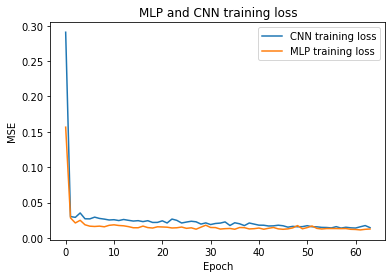

In [11]:
# Plot training & validation loss values
fig = plt.figure()
plt.plot(history_cnn.history['loss'], label = 'CNN training loss')
plt.plot(history_mlp.history['loss'], label = 'MLP training loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.title('MLP and CNN training loss')
fig.savefig('cnn_mlp_training_loss.png', fig_size = (8,6))

In [12]:
y_pred_cnn = []
y_pred_mlp = []
ground_truth = []

num_segments = int(data_scaled.shape[0] / prediction_time)
for i in range(num_segments - 1):
    start_index = i * prediction_time
    end_index = start_index + time_window_length
    if end_index >= len(data_scaled):
        break
    X_in = data_scaled[start_index : end_index].reshape(1,-1,1)    
    pred_cnn = model_cnn.predict(X_in)
    pred_mlp = model_mlp.predict(X_in.reshape(1,-1))
    y_pred_cnn.append(pred_cnn)
    y_pred_mlp.append(pred_mlp)

y_pred_cnn = np.array(y_pred_cnn).ravel()
y_pred_mlp = np.array(y_pred_mlp).ravel()

In [17]:
ground_truth = data_scaled[prediction_time: prediction_time + len(y_pred_mlp)].ravel()

### Result Analysis

After the models being trained, we used them to predict the bitcoin price. We have a sliding window which including the 15 days of bitcoin data used as the model input and predict the bitcoin price for following 5 days, then we move this sliding window by 5 days to predict the next 5 days. It is not suprised that in the first 1828 days, the predictions from both of the model almost have no error as this part of data has been used as training data. What is interesting is that even the testing data section, the predictions from both of the models are very good. The MSE of CNN model is 0.039 and MSE of MLP model is 0.0479, although the CNN model using less than half of the parameters compared to the MLP model. This results demonstrate that CNN should be preferred model even in the time series analysis. This is in fact not counterintuitive. We human being is also trying to recognize the patterns from the time series data to help us predict the future and CNN excels in identitying the pattern in both 1D sequential data and 2D image data. 

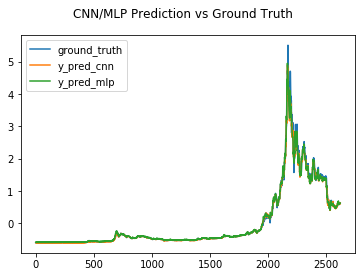

In [25]:
fig, axs = plt.subplots()
fig.suptitle('CNN/MLP Prediction vs Ground Truth')
axs.plot(ground_truth, label='ground_truth')
axs.plot(y_pred_cnn, label='y_pred_cnn')
axs.plot(y_pred_mlp, label='y_pred_mlp')
plt.legend(loc='best')
fig.savefig('prediction_vs_gt.png', fig_size = (8,6))

In [15]:
cnn_error = np.abs(y_pred_cnn - ground_truth)
mlp_error = np.abs(y_pred_mlp - ground_truth)
mse_cnn = np.sum(cnn_error) / np.sum(np.abs(ground_truth)) 
mse_mlp = np.sum(mlp_error) / np.sum(np.abs(ground_truth)) 
print('MSE CNN model', mse_cnn)
print('MSE MLP model', mse_mlp)

MSE CNN model 0.039000332830261206
MSE MLP model 0.04797833364345617


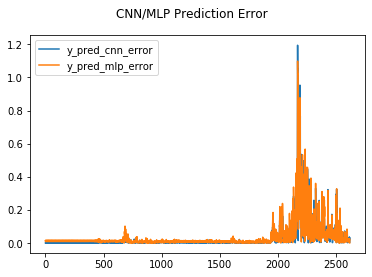

In [23]:
fig, axs = plt.subplots()
fig.suptitle('CNN/MLP Prediction Error')
axs.plot(cnn_error, label='y_pred_cnn_error')
axs.plot(mlp_error, label='y_pred_mlp_error')
plt.legend(loc='best')
fig.savefig('prediction_error.png', fig_size = (8,6))